In [6]:
%%capture
! pip install timm einops

In [2]:
! git clone https://github.com/jacobgil/vit-explain vit_explain

Cloning into 'vit_explain'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 96 (delta 36), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from vit_explain.vit_rollout import VITAttentionRollout
from vit_explain.vit_grad_rollout import VITAttentionGradRollout

%matplotlib inline

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/2.validation/2.validation/img/00.png'
valid_mak_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/2.validation/2.validation/mask/00.png'

In [3]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_mak_path), (224, 224))

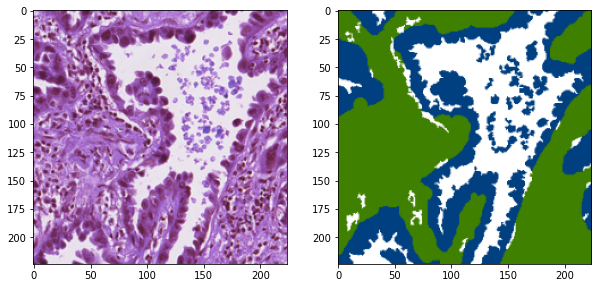

In [4]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [5]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [7]:
def reshape_transform(tensor, height=14, width=14):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [6]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    mask = cv2.resize(mask, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [10]:
valid_img_tensor = preprocess_image(valid_img).to(device)
#valid_img_tensor = preprocess_image(valid_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

In [ ]:
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if '16' in x and 'deit' not in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/accu_cutmix_aug_model_vit_base_patch16_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/border_cutmix_model_vit_base_patch16_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/border_cutmix_model_vit_base_patch16_224_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_vit_base_patch16_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch16_224_1.pth']

# Model 0: model_vit_16_224_1.pth

In [ ]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_vit_base_patch16_224.load_state_dict(torch.load(f=model_weights[2], map_location=device))

<All keys matched successfully>

In [ ]:
%%capture
model_vit_base_patch16_224.eval()

## 01. Attention Rollout

In [ ]:
attention_rollout = VITAttentionRollout(model_vit_base_patch16_224, head_fusion='mean', discard_ratio=0.9)

In [ ]:
mask_0 = attention_rollout(valid_img_tensor)
#mask_1 = attention_rollout(valid_img_tensor)
#mask_2 = attention_rollout(valid_img_tensor)

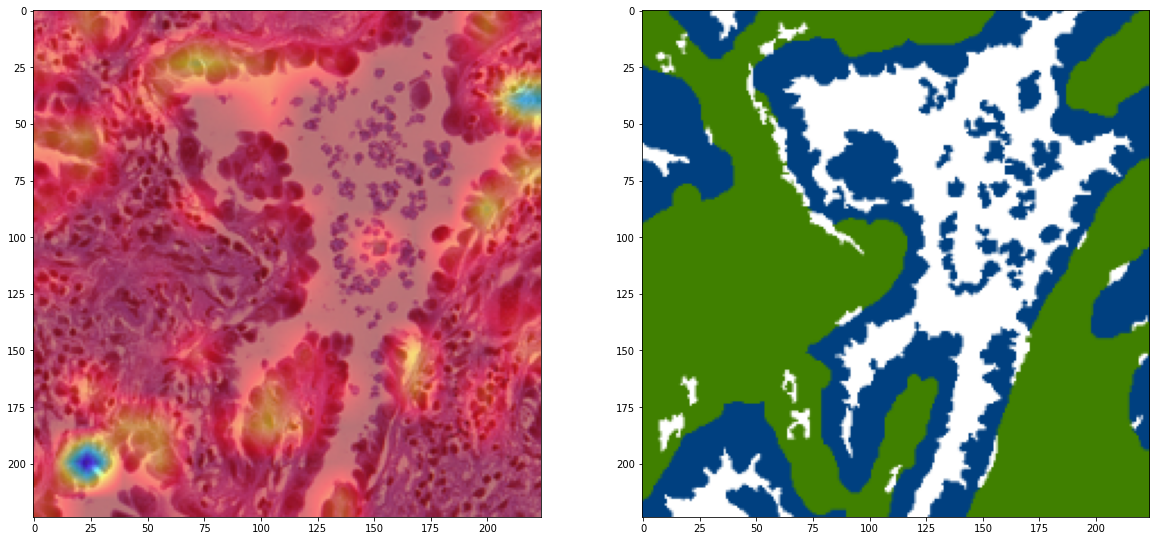

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 2, 1)
plt.imshow(show_mask_on_image(valid_img, mask_0))
'''
ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_mask_on_image(valid_img, mask_1))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_mask_on_image(valid_img, mask_2))
'''
ax = fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

## 02 Attention Grad Rollout

In [ ]:
grad_rollout = VITAttentionGradRollout(model_vit_base_patch16_224, discard_ratio=0.9)

In [ ]:
mask_0 = grad_rollout(valid_img_tensor, category_index=0)
mask_1 = grad_rollout(valid_img_tensor, category_index=1)
mask_2 = grad_rollout(valid_img_tensor, category_index=2)

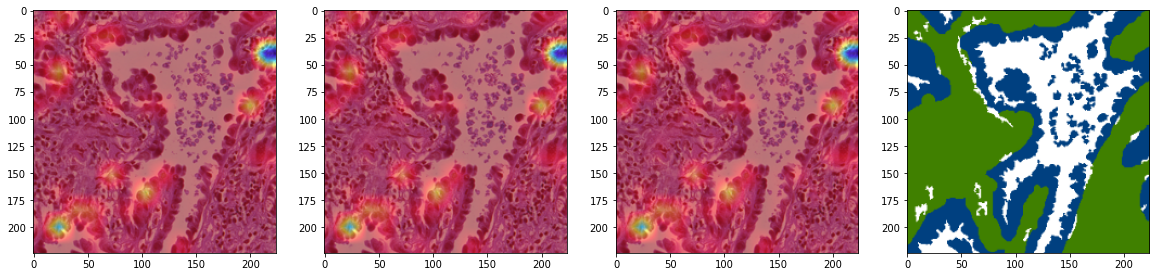

In [ ]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_mask_on_image(valid_img, mask_0))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_mask_on_image(valid_img, mask_1))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_mask_on_image(valid_img, mask_2))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# Transformer Explainabillity - Hila Chefer

In [16]:
! git clone https://github.com/hila-chefer/Transformer-Explainability.git Transformer_Explainability

Cloning into 'Transformer_Explainability'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 362 (delta 104), reused 69 (delta 65), pack-reused 235
Receiving objects: 100% (362/362), 3.24 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [11]:
os.chdir(f'./Transformer_Explainability')

In [12]:
#@title WSSS4LUAD class indices to names

CLS2IDX = {0: 'tumor',
           1: 'stroma',
           2: 'normal',}

In [13]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

In [14]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      ])
  return preprocessing(img.copy())

In [15]:
valid_img_tensor = preprocess_image(valid_img)

In [16]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print 3 predictions
    prob = torch.sigmoid(predictions)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('3 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [18]:
#model_weights = ['/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/' + x for x in os.listdir('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models') if 'hila' in x and 'deit' not in x]
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if 'hila' in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/hila_vit_base_patch16_224_01.pth']

In [19]:
model = vit_LRP(pretrained=False, num_classes = 3).to(device)
model.load_state_dict(torch.load(model_weights[0], map_location=device))
model.eval()
attribution_generator = LRP(model)

In [20]:
valid_img_tensor.shape

torch.Size([3, 224, 224])

In [21]:
output = model(valid_img_tensor.unsqueeze(0).to(device))
print_top_classes(output)

3 classes:
	0 : tumor 		value = 8.998	 prob = 100.0%
	2 : normal		value = -3.379	 prob = 3.3%
	1 : stroma		value = -5.399	 prob = 0.5%


In [22]:
tumor = generate_visualization(valid_img_tensor, class_index=0)
stroma = generate_visualization(valid_img_tensor, class_index=1)
normal = generate_visualization(valid_img_tensor, class_index=2)

AssertionError: Torch not compiled with CUDA enabled

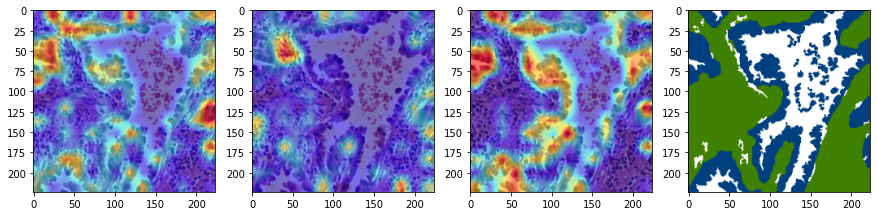

In [58]:
fig = plt.figure(figsize=(15, 30))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(tumor)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(stroma)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(normal)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))